In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad,sonoff
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys


# 1. Create a gaussian spectrum with noise, compute the baseline, remove it, then add the baseline back in

### First, create the spectrum

In [2]:
npts = 1000
x = np.arange(npts)
y = 3.1415927+np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))

### compute the baseline, exclude channels 300 to 700, don't remove it.
The red line shows the computed baseline

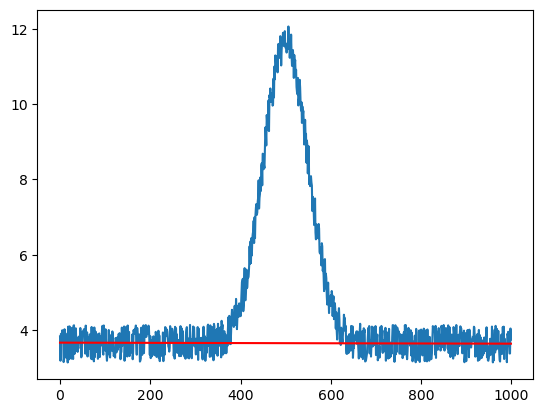

In [3]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
s.baseline(1,exclude=[300,700],remove=False)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

### print some statistics [mean, rms, min, max], show the baseline model function

In [4]:
print(s.stats())
s.bshow()

(<Quantity 4.65160055 K>, 2.174533468939273, <Quantity 3.14362286 K>, <Quantity 12.06019854 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                    c1          
            K                   K / um        
    ------------------ -----------------------
    3.6698407319599795 -2.7360089585838936e-05


### now do again it and remove the baseline

(<Quantity 0.99542618 K>, 2.174524321483614, <Quantity -0.52575275 K>, <Quantity 8.40420201 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                    c1          
            K                   K / um        
    ------------------ -----------------------
    3.6698407319599795 -2.7360089585838936e-05


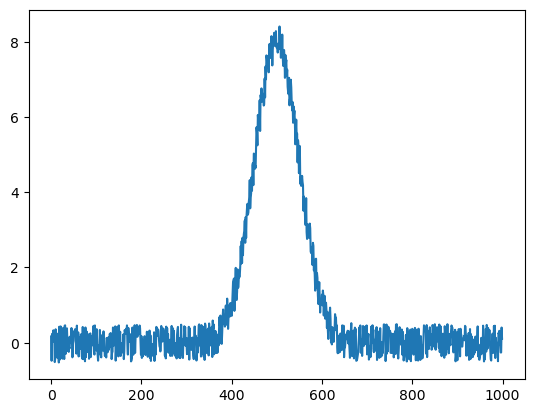

In [5]:
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,exclude=[300,700],remove=True)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
print(s.stats())
s.bshow()

In [6]:
### undo the baseline removal.  Stats shows it has been added back in and the spectrum is restored

In [7]:
s._undo_baseline()
print(s.stats())
s.bshow()


(<Quantity 4.65160055 K>, 2.174533468939273, <Quantity 3.14362286 K>, <Quantity 12.06019854 K>)
baseline model None


-------------

# 2. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [8]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)

==SDFITSLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
doing pandas for HDU 1
==GBTLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
0 OBJECT: ['NGC2415']
0 SCAN: [152, 153]
0 SAMPLER: ['A1_0', 'A2_0', 'A1_1', 'A2_1', 'A1_2', 'A2_2', 'A1_3', 'A2_3', 'A1_4', 'A2_4']
0 SIG: ['T']
0 CAL: ['F', 'T']
0 PROCSEQN: [1, 2]
0 PROCSIZE: [2]
0 OBSMODE: ['OnOff:PSWITCHON:TPWCAL', 'OnOff:PSWITCHOFF:TPWCAL']
0 SIDEBAND: ['L']


### Print the summary.  Yes, I need to clean this up.

In [9]:
p.summary()[0]

/home/mpound/src/dysh/src/dysh/fits/gbtfitsload.py:85: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  _df = df[df.columns & show].copy()


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM
0,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
1,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
2,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
3,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
4,152,NGC2415,3784.0,OnOff,1,1.612231,1,1,285.951496,42.100624,0
...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,1.667359,3,1,287.149353,40.652970,0
6036,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6037,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6038,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0


### check out some important columns.  Note the clever selection mechanism

In [10]:
columns = ["SCAN","PROC","PROCSEQN","IFNUM","PLNUM","SIG","CAL","TSYS","TCAL", "OBSMODE","FDNUM"]
df = p._ptable[0]
df[df.columns & columns][0:50]
#df[(df['SIG'] == 'F') & (df['CAL']=='T')][(df.columns & columns)]

/tmp/ipykernel_425117/3272325.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df[df.columns & columns][0:50]


,TSYS,SCAN,OBSMODE,TCAL,PROCSEQN,SIG,CAL,IFNUM,PLNUM,FDNUM,PROC
0,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1,T,F,0,1,0,OnOff
1,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1,T,T,0,1,0,OnOff
2,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1,T,F,0,0,0,OnOff
3,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1,T,T,0,0,0,OnOff
4,1.0,152,OnOff:PSWITCHON:TPWCAL,1.602189,1,T,F,1,1,0,OnOff
5,1.0,152,OnOff:PSWITCHON:TPWCAL,1.602189,1,T,T,1,1,0,OnOff
6,1.0,152,OnOff:PSWITCHON:TPWCAL,1.575624,1,T,F,1,0,0,OnOff
7,1.0,152,OnOff:PSWITCHON:TPWCAL,1.575624,1,T,T,1,0,0,OnOff
8,1.0,152,OnOff:PSWITCHON:TPWCAL,1.441578,1,T,F,2,1,0,OnOff
9,1.0,152,OnOff:PSWITCHON:TPWCAL,1.441578,1,T,T,2,1,0,OnOff


## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [11]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

PSSCAN nrows = 302


In [12]:
psscan.calibrate()

### the raw calibrated numpy array

In [13]:
psscan._calibrated[0]

array([-0.36949378,  0.6447438 , -1.0699384 , ...,  1.0231373 ,
        0.17274837,  0.18792354], dtype=float32)

### A single integration of the calibrated Spectrum

In [14]:
spec1 = psscan.calibrated(0)

Text(0, 0.5, '$T_a$ (K)')

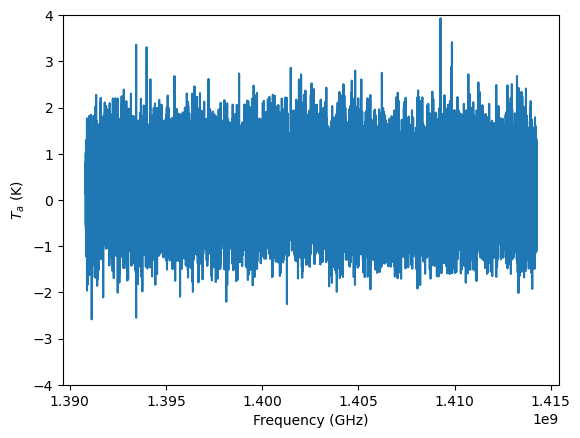

In [25]:
fig,ax = plt.subplots()
ax.set_ylim([-4,4])
ax.plot(spec1.spectral_axis,spec1.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")

In [16]:
## ignore this
if False:
    flx = np.mean(psscan._calibrated[np.arange(0,len(psscan._calibrated),4)])
    fig,ax = plt.subplots()
    ax.set_ylim([-4,4])
    ax.plot(psscan.calibrated(0).spectral_axis,flx)
    all(psscan.calibrated(0).spectral_axis==psscan.calibrated(3).spectral_axis),all(psscan.calibrated(4).spectral_axis==psscan.calibrated(7).spectral_axis)

### The average spectrum.  
Note this will be encapsulated in a average() method.
Compare this with GBTIDL `getps, 152`

T_sys = 21.32320216292886


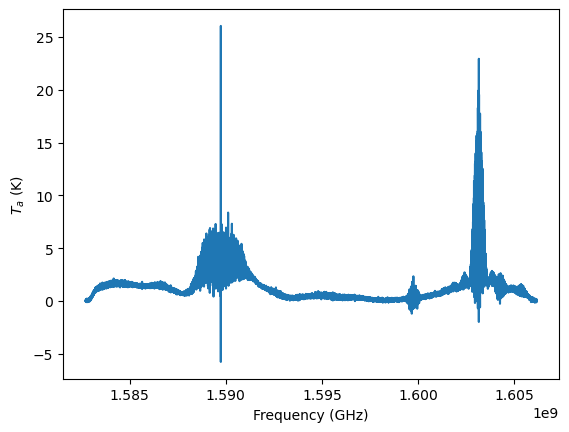

In [26]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [23]:
psscan = p.getps(153,plnum=1,ifnum=1)
psscan.calibrate()

PSSCAN nrows = 302


T_sys = 21.32320216292886


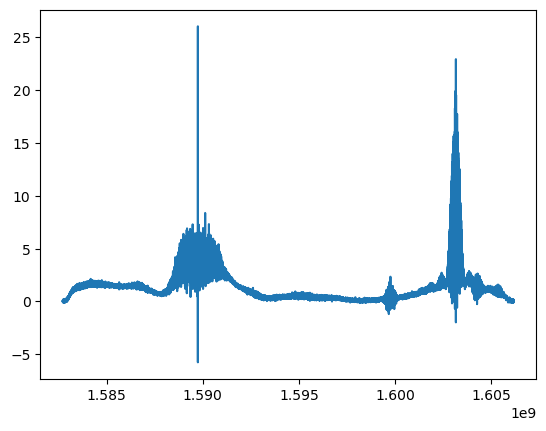

In [24]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

-----
# Debugging from here down.

In [ ]:
df = p._ptable[0]
len(p.select('OBJECT','NGC2415',p._ptable[0]))//p.npol(0)

In [ ]:
p.index(0).iloc[psscan._scanrows["OFF"]]["CAL"]

In [ ]:
psscan.calibrate()

In [ ]:
df = p._ptable[0]
scans = [152,153]
df2=df[df["SCAN"].isin([152])]
df3=df[df["SCAN"].isin([153])]
df4=df[df["SCAN"].isin([156])]
un = df2.index.union(df3.index)
un2=df2.index
un3=df3.index
df["SCAN"].iloc[un2]
df3.reindex(un2).index

In [ ]:
on = [152,154,156]
off = [153,155,157]
scans = [152,155]
onrequested = set(on).intersection(scans)
offrequested = set(off).intersection(scans)
sons = list(onrequested.copy())
soffs = list(offrequested.copy())
missingoff = []
missingon = []
setoff = set(off)
seton = set(on)
for i in onrequested:
    expectedoff = i+1
    if len(setoff.intersection([expectedoff])) == 0:
        missingoff.append(expectedoff)
    else:
        soffs.append(expectedoff)
for i in offrequested:
    expectedon = i-1
    if len(seton.intersection([expectedon])) == 0:
        missingon.append(expectedon)
    else:
        sons.append(expectedon)
if len(missingoff) > 0:
    raise ValueError(f"For the requested ON scans {onrequested}, the OFF scans {missingoff} were not present in bintable {bintable}")
if len(missingon) > 0:
    raise ValueError(f"For the requested OFF scans {offrequested}, the ON scans {missingon} were not present in bintable {bintable}")
print("ON",sorted(sons))
print("OFF",sorted(soffs))

In [ ]:
scanlist=p.onoff_scan_list()
print(scanlist)
#scanlist = p.onoff_scan_list([152])
#print(scanlist)
scanlist = p.onoff_scan_list([153])
print(scanlist)
scanlist = p.onoff_scan_list([152,153])
print(scanlist)
scanlist = p.onoff_scan_list(152)
print(scanlist)

In [ ]:
print(sonoff(p.index(0)["SCAN"],p.index(0)["PROCSEQN"]))
myscans = set(sorted([153,155]))
scanlist=p.onoff_scan_list()
print(scanlist)
allscans = set(sorted(scanlist["ON"]+scanlist["OFF"]+[1,2,3,4,5]))
print(allscans)
z=allscans.intersection(myscans)
zz =allscans.difference(myscans)
zzz=myscans.difference(allscans)
print(z,zz,zzz)

In [ ]:
psscan = p.getps(scans=[152])

In [ ]:
df = p._ptable[0]
rows=list(df[df["SCAN"].isin(scans["ON"])].index)
df

In [ ]:
rows=p.onoff_rows()
rows

In [ ]:
show = ["SCAN", "PROCSEQN", "PROCSIZE", "_OBSTYPE"]
df=df[df.columns & show]
df[df["_OBSTYPE"]=="PSWITCHOFF"]

In [ ]:
dict(p._ptable[0].iloc[0])

In [ ]:
df["RESTFREQ"]/=1E9
df["RESTFREQ"]

In [ ]:
show = ["SCAN", "OBJECT", "OBSMODE", "VELOCITY", "PROCSCAN", "PROCSEQN", "PROCTYPE", "PROCSIZE", "RESTFREQ", "IFNUM","FEED", "AZIMUTH", "ELEVATIO", "FDNUM"] 
scan = [60,61]
_df = df[df.columns & show].reindex(columns=show)

In [ ]:
_df["OBSMODE"].str.split(':',expand=True)

In [ ]:

_df[(_df["SCAN"]>=scan[0]) & ( _df["SCAN"] <= scan[1])]

In [ ]:
df["SCAN"]

In [ ]:
df['PROCTYPE']